# 논문의 제목과 초록에 사용된 명사 빈도 비교
논문에는 논문의 제목과 논문을 간략히 설명하는 초록이 있다.

단어를 가지고 논문을 검색했을 때, 나오는 제목과 초록에서 사용되는 명사의 빈도수를 각각 확인한다.

각 단어마다 딕셔너리 형태로 몇개가 있는지 저장하고, 빈도의 크기를 상대적으로 보기 편하게 WordCloud 형태로 만든다.

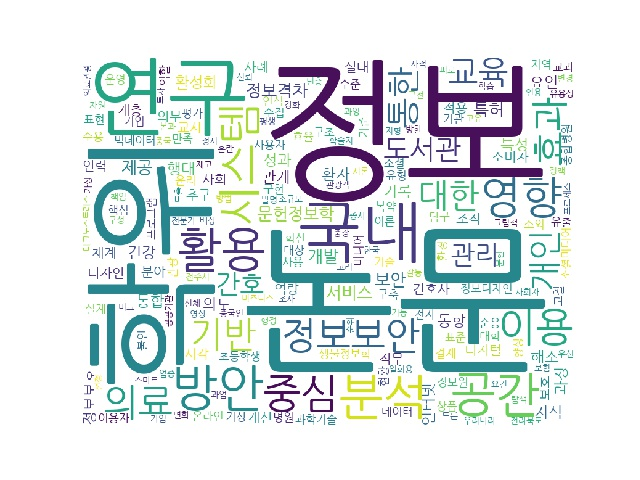

논문은 아래 페이지에서 검색했다.  
https://scienceon.kisti.re.kr/

## 목차
1. 논문 검색 페이지 구조
2. 웹 크롤링 및 명사 사용 빈도 비교


## 1. 논문 검색 페이지 구조
https://scienceon.kisti.re.kr/ 는 아래 사진과 같이 이루어져 있다.  

여기서 논문을 보기 위해서는 검색창에 원하는 단어를 검색해야 한다.


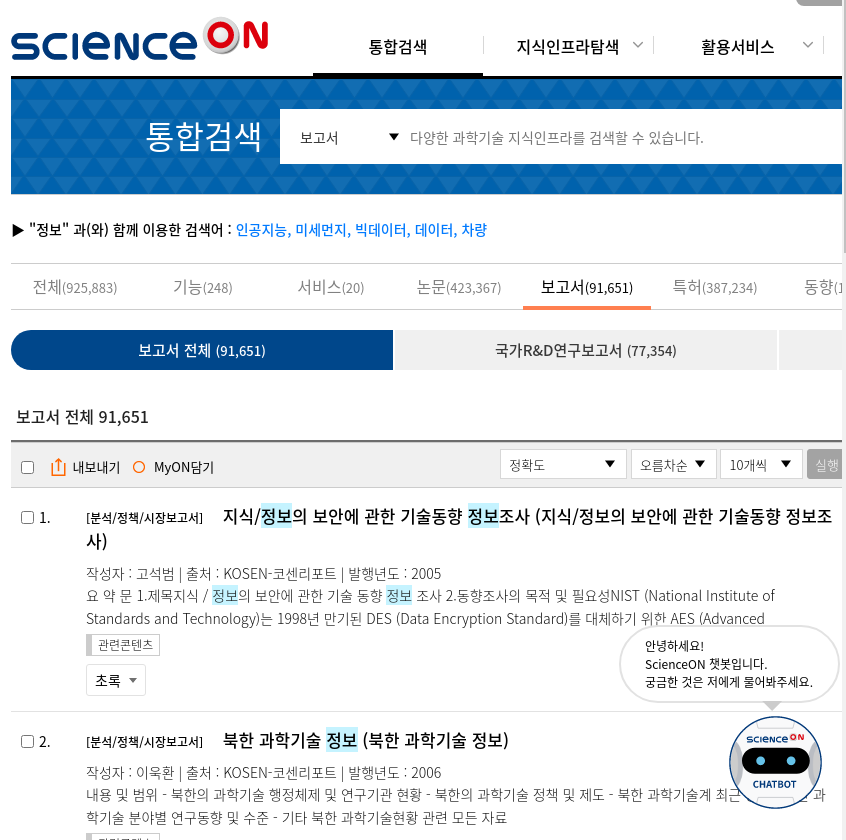

이때까지 크롤링했던 페이지는 get 방식으로 다른 페이지를 클릭하면 url에 form 데이터를 붙입니다.  
https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=%EC%A0%95%EB%B3%B4

하지만 현재 페이지 같은 경우에는 post 방식으로 url에는 변화가 없습니다.  
https://scienceon.kisti.re.kr/srch/selectPORSrchReport.do

post를 할때 form 데이터는 요청의 body 부분에 들어가 url에서는 안보입니다.

웹 크롤링을 할때 원하는 단어의 논문 리스트를 얻기 위해서는 아래 형태의 formdata에서 원하는 페이지의 정보를 넣고 웹 페이지 요청과 함께 웹 서버로 넘겨줘야 됩니다.

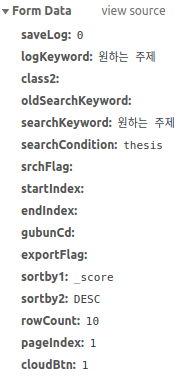

rowCount : 논문 리스트 수  
pageindex : 페이지 번호

가져온 페이지는 아래와 같이 제목과 초록 부분이 있습니다.
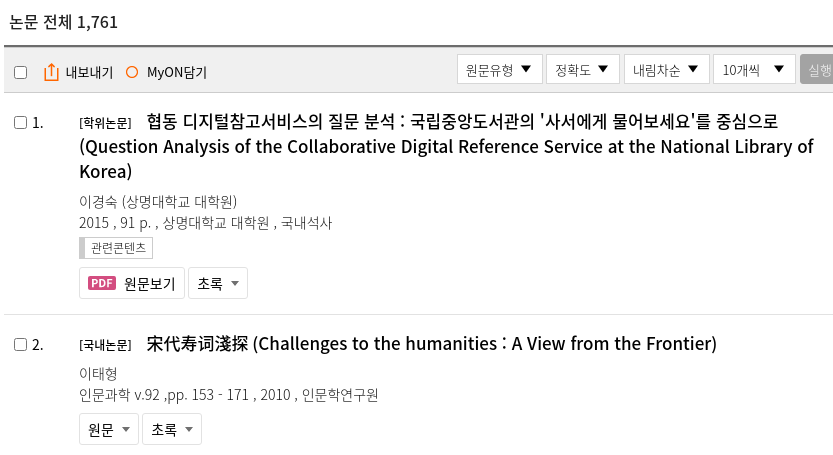

아래와 같이 `<div class='result_item'>` 태그 안에 한 논문의 정보가 있다.
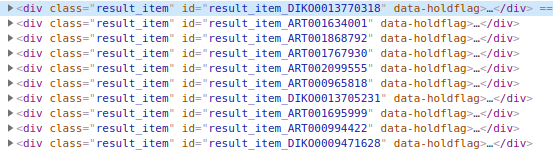

위 태그 안에  
`<a title='상세보기'>` 태그에 제목에 대한 정보가 있다.
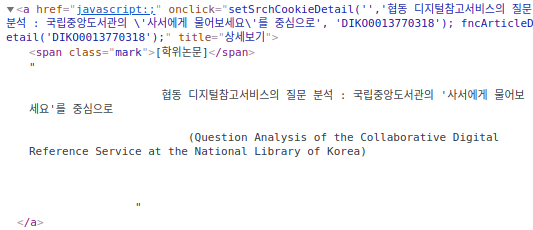

`<div class="item_content hidden abs">` 안에는 초록에 대학 정보가 있다.
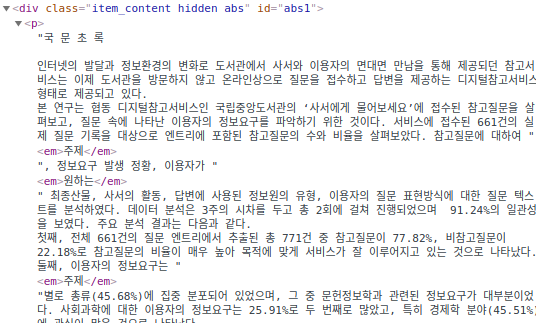

## 2. 웹 크롤링 및 명사 사용 빈도 비교

In [2]:
from konlpy.tag import Okt
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup as bs
from openpyxl import load_workbook as load

In [ ]:


url="https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiView.kci?sereArticleSearchBean.artiId=ART001303851"
html=urlopen(url)


아래는 위 과정의 코드이다.  
url 과 contents를 먼저 정의했다.

In [2]:
URL='https://scienceon.kisti.re.kr/srch/selectPORSrchArticleList.do'
contents={
    'saveLog': '0',
    'logKeyword': '',         #원하는 단어
    'class2': '',             #'국내논문','해외논문','학위논문' 선택 
    'oldSearchKeyword':'' ,   
    'searchKeyword': '',      #원하는 단어
    'searchCondition': 'thesis',
    'srchFlag': '',
    'startIndex':'', 
    'endIndex': '',
    'gubunCd': '',
    'exportFlag': '',
    'sortby1': '_score',  # 정렬 종류
    'sortby2': 'DESC',    # 내림차순
    'rowCount': '10',  # 페이지당 논문 겟수
    'pageIndex': '1',   # 페이지 인덱스
    'cloudBtn': '1'
}

위에 딕셔너리 형태에서 워하는 페이지 정보를 넣고 웹 서버로 보낸 뒤에  
받은 파일에서 각 논문마다 제목, 초록 태그를 찾고 text를 추출합니다.

초록이 없는 논문은 추출에서 제외했습니다.

In [3]:
def get_link(keyword):
    a_links=[]
    b_links=[]
    fail=[]
    
    contents['logKeyword']=keyword
    contents['searchKeyword']=keyword    # 단어 입력
    
    for page in range(1,11):
        contents['pageIndex']=str(page)   # 1~10페이지까지 검색
        req=requests.post(URL,contents)   # 웹 서버에 웹페이지 요청
        code = req.status_code            # 응답 성공 여부
#         print(code)
        if code==200:                     
            soup=bs(req.text) 
            div = soup.find_all('div',{'class','result_item'})
            
            for data in div:
                a_tag=data.find('a',{'title':'상세보기'})
                a_tag=a_tag.get_text()
                a_tag=a_tag.replace('\n','').replace('\t','').replace('\r','')
                
                try:                        # 초록이 없는 경우 제외
                    box_st1=data.find('div',{"class":"item_content hidden abs"})
                    box_st1=box_st1.get_text()
                    
                except:                      # 초록이 없는 논문 리스크 저장
                    num=data.find('span',{'class','num'}).get_text()
                    fail.append((num,a_tag.replace('  ','')))
                    
                else:                        # 제목과 초록이 있으면 각각 리스트 저장
                    a_links.append(a_tag)
                    b_links.append(box_st1)
        else:                                 # 응답실패
            print('HTTP Error',code)
            
    print("초록 없음 : ")   # 초록 없는것 출력
    for row in fail:
        print(row)
        
    return a_links,b_links

- 초록이 없는 경우
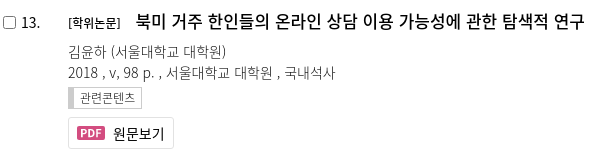

아래 함수는 위에서 가져온 논문 제목과 초록을 엑셀로 저장하는 함수이다.

제목을 A열, 초록을 B열에 저장했다.

In [4]:
def save_excel(a_links,b_links,title='test'):
    wb = load('test.xlsx')
    ws=wb.create_sheet(title)
    print('전체 길이',len(a_links))
    
    try:
        for i in range(len(a_links)):
            ws['A'+str(i+1)]=a_links[i]
        for j in range(len(b_links)):
            ws['B'+str(j+1)]=b_links[j]
        wb.save('test.xlsx')
        
    except Exception as e:
        print(e)
        
    finally:
        wb.close()  

아래는 가져온 논문의 글을 okt를 통해 형태소 분석하고,  
나온 명사의 빈도 수를 구한다.

그 다음 WordCloud을 통해 명사의 빈도 수를 상대적으로 시각화한다.

In [6]:
ok=Okt()
ok.pos("논문의 제목과 초록에 사용된 명사 빈도 비교")

[('논문', 'Noun'),
 ('의', 'Josa'),
 ('제목', 'Noun'),
 ('과', 'Josa'),
 ('초록', 'Noun'),
 ('에', 'Josa'),
 ('사용', 'Noun'),
 ('된', 'Verb'),
 ('명사', 'Noun'),
 ('빈도', 'Noun'),
 ('비교', 'Noun')]

In [7]:
mpl.use('TkAgg')  # 그래프 지원 

PATH='/usr/share/fonts/NanumFont/NanumGothic.ttf'  # 글꼴 
def get_wc(content,title):
    ok=Okt()
    result={}
    for c in content:          
            temp = ok.pos(c)  # 형태소 분석
            for t in temp:
                if t[1] =="Noun" and len(t[0])>1:  # 명사이고 글자수가 1 이상이면 실행
                    
                    if not (t[0] in result):       # 딕셔너리에 t[0]가 없으면 key값을 t[0]으로 선언
                        result[t[0]]=0
                    result[t[0]]+=1
                    
    result = sorted(result.items(),key = lambda x:x[1],reverse=True)  겟수가 많은것부터 정렬
    print(dict(result))
    wc=WordCloud(font_path=PATH,background_color = 'white',width = 800, height=600)
    plt.axis('off')
    plt.imshow(wc.generate_from_frequencies(dict(result)))
    plt.savefig(title+'.jpg')           # 저장
    



In [9]:
if __name__=="__main__":
#     try:
#         while True:
            keyword = input('검색어를 입력해주세요. : ')
#             if keyword=="exit":
#                 print('종료되었습니다.')
#                 break
            a_links,b_links=get_link(str(keyword))
            title = input('엑셀 시트명을 입려해주세요 : ')
            save_excel(a_links,b_links,title=title)
            a,b=input('이미지 이름을 입력해주세요. (1: 제목, 2: 초록) : ').split()
            get_wc(a_links,a)
            get_wc(b_links,b)
#     except Exception as e:
#         print(e)

검색어를 입력해주세요. : 정보
초록 없음 : 
('13.', '[학위논문]지질정보 시스템 ')
('24.', '[학위논문]지리정보 메타데이터 관리 시스템 구현 ')
('29.', '[학위논문]대학생의 정신건강정보 이해능력(Mental Health Literacy)에 미치는 영향 요인(Factors Influencing on Mental Health Literacy Among University Students) ')
('36.', '[국내논문]정보경찰 교육의 피이드백 시스템 확보방안(A Study on Effective Feed Back System of Intelligence Police Education) ')
('48.', "[국내논문]간호정보시스템이 간호업무에 미치는 영향 - 직？간접 간호시간 중심으로(The Effects of Nursing Information System on the Nursing Job-Focused on Direct and Indirect Nursing Time, the Number of Cases and of Patient's Treatment Fees) ")
('98.', '[학위논문]건강정보 이해능력을 고려한 노인 당뇨병 자기관리 프로그램 개발 및 효과평가 ')
엑셀 시트명을 입려해주세요 : 정보
전체 길이 94
이미지 이름을 입력해주세요. (1: 제목, 2: 초록) : 정보_title 정보_body
{'논문': 95, '정보': 82, '학위': 66, '연구': 48, '국내': 28, '방안': 14, '활용': 13, '분석': 13, '공간': 13, '영향': 11, '시스템': 11, '이용': 9, '중심': 9, '정보보안': 9, '효과': 9, '의료': 9, '기반': 8, '대한': 7, '개인': 7, '통한': 7, '교육': 7, '도서관': 7, '관리': 6, '간호': 6, '문헌정보학': 5, '특허': 5, '정보격차': 5, '보안': 5, '개발': 5, '제공': 5, '서비스'

- "정보" 키워드 제목  
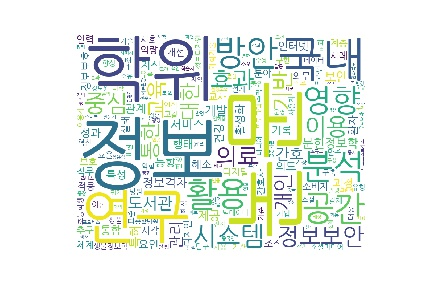


- "정보" 키워드 초록  
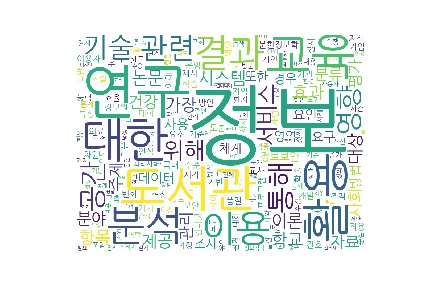

# 연도별 트랜드(미완성)

In [21]:
from konlpy.tag import Okt
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup as bs
from openpyxl import load_workbook as load

In [ ]:
import json

URL='https://scienceon.kisti.re.kr/srch/selectPORSrchArticleList.do'
contents={
    'saveLog': '0',
    'logKeyword': '정보 !지식',         #원하는 단어
    'class2': '',             #'국내논문','해외논문','학위논문' 선택 
    'oldSearchKeyword':'' ,   
    'searchKeyword': '',      
    'searchCondition': 'thesis',
    'srchFlag': 'detail',
    'startIndex':'', 
    'endIndex': '',
    'gubunCd': '',
    'exportFlag': '',
    'searchRange': 'ALL,국내논문,해외논문,학위논문',
    'dgType': 'ALL',
    'dataType': 'ALL',
    'freeFlagYn': 'ALL',
    'absFlagYn': '1',
    'dselect': 'BI,TI,AU',
    'dsearch': '정보 !지식',
    'dandor': 'AND',
    'dateRange': '2000,2019',
    'sortby1': '_score',  # 정렬 종류
    'sortby2': 'DESC',    # 내림차순
    'rowCount': '10',  # 페이지당 논문 겟수
    'pageIndex': '1',   # 페이지 인덱스
    'cloudBtn': '1'
}


In [116]:
URL='https://scienceon.kisti.re.kr/srch/selectPORSrchArticleList.do'
contents={
    'saveLog': '0',
    'logKeyword': '정보 !지식',         #원하는 주제
    'class2': '',             #'국내논문','해외논문','학위논문' 선택 
    'oldSearchKeyword':'' ,   
    'searchKeyword': '',      
    'searchCondition': 'thesis',
    'srchFlag': 'detail',
    'startIndex':'', 
    'endIndex': '',
    'gubunCd': '',
    'exportFlag': '',
    'searchRange': ['ALL','국내논문','해외논문','학위논문'],
    'dgType': 'ALL',
    'dataType': 'ALL',
    'freeFlagYn': 'ALL',
    'absFlagYn': '1',
    'dselect': ['BI','TI','AU'],
    'dsearch': '정보 !지식',
    'dandor': 'AND',
    'dateRange': [], #'2000','2019'
    'sortby1': '_score',  # 정렬 종류
    'sortby2': 'DESC',    # 내림차순
    'rowCount': '10',  # 페이지당 논문 겟수
    'pageIndex': '1',   # 페이지 인덱스
    'cloudBtn': '1'
}


In [122]:
URL='https://scienceon.kisti.re.kr/srch/selectPORSrchArticleList.do'
contents={
    'saveLog': '0',
    'logKeyword': '정보',         #원하는 단어
    'class2': '',             #'국내논문','해외논문','학위논문' 선택 
    'oldSearchKeyword':'' ,   
    'searchKeyword': '',      
    'searchCondition': 'thesis',
    'srchFlag': 'detail',
    'startIndex':'', 
    'endIndex': '',
    'gubunCd': '',
    'exportFlag': '',
    'searchRange': ['ALL','국내논문','해외논문','학위논문'],
    'dgType': 'ALL',
    'dataType': 'ALL',
    'freeFlagYn': 'ALL',
    'absFlagYn': '1',
    'dselect': ['BI','TI','AU'],
    'dsearch': '정보',
    'dandor': 'AND',
    'dateRange': [], #'2000','2019'
    'sortby1': '_score',  # 정렬 종류
    'sortby2': 'DESC',    # 내림차순
    'rowCount': '100',  # 페이지당 논문 겟수
    'pageIndex': '1',   # 페이지 인덱스
    'cloudBtn': '1'
}

req=requests.post(URL,contents)   
soup=bs(req.text) 

div = soup.find('div',{'class','paper_content mb40 '})
body=div.form
dic_contents={
    'srchType':[],
    'cn':[],
    'dbt':[],
    'dbt2':[],
    'bibctrlno':[],
    'artctrlno':[],
    'pubyear':[],
    'subdoctype':[],
    'urlflag':[],
    
}

for row in body.find_all("input"):
    key=row.attrs['name']
    value=row.attrs['value']
    dic_contents[key].append(value)


In [123]:
dic_contents

{'srchType': ['articles'],
 'cn': ['JAKO199216837844151',
  'JAKO201715048149769',
  'JAKO201303537265404',
  'JAKO201618850656645',
  'JAKO201213956027595',
  'JAKO199111920382557',
  'JAKO199916837843187',
  'JAKO202115463028733',
  'JAKO200709906241660',
  'JAKO200111920894339',
  'JAKO199316837844118',
  'JAKO200211921525979',
  'JAKO201429765167562',
  'JAKO201426955811776',
  'JAKO200373605845561',
  'JAKO200516837842396',
  'JAKO201426955811781',
  'JAKO199616837843664',
  'JAKO200011920383803',
  'JAKO200131037072472',
  'JAKO200710912645092',
  'JAKO200245940755769',
  'JAKO199816837843514',
  'JAKO200116837842983',
  'JAKO202020264316520',
  'JAKO200311922287827',
  'JAKO201518564243863',
  'JAKO198811920382374',
  'JAKO199816837843516',
  'JAKO200116837843011',
  'JAKO202026759806768',
  'JAKO200216837842942',
  'JAKO201808962643734',
  'NART56246731',
  'JAKO199973873781718',
  'JAKO201017337333842',
  'JAKO198516837846788',
  'JAKO201414938219230',
  'JAKO199463369790762',

In [104]:
contents={
    'srchType': 'articles',
'cn': 'JAKO200111920894339',
'dbt': 'NART',
'dbt2': 'JAKO',
'bibctrlno': '290996',
'artctrlno': '36435442',
'pubyear': '2001',
'subdoctype': '국내논문',
'urlflag': '1'
         }

In [108]:
contents={
    'srchType': 'articles',
'cn': ['JAKO200111920894339','JAKO200011920383803'],
'dbt': ['NART','NART'],
'dbt2': ['JAKO','JAKO'],
'bibctrlno': ['290996','290722'],
'artctrlno': ['36435442','34706053'],
'pubyear': ['2001','2000'],
'subdoctype': ['국내논문','국내논문'],
'urlflag': ['1','1']
         }

In [106]:
contents={
    'srchType': 'articles',
'cn': 'JAKO200111920894339,JAKO200011920383803',
'dbt': 'NART',
'dbt2': 'JAKO',
'bibctrlno':'290996,290722',
'artctrlno': '36435442,34706053',
'pubyear': '2001,2000',
'subdoctype': '국내논문',
'urlflag': '1'
         }

In [132]:
URL='https://scienceon.kisti.re.kr/srch/searchArticleUrlInfoList.do'
req=requests.post(URL,dic_contents)   # 웹 서버에 웹페이지 요청
soup=req.json() 
print(soup)
# # code = req.status_code            # 응답 성공 여부
# div = soup.find_all('div',{'class','result_item'})

# for data in div[:2]:
# #     print(data.find('button',{'class':'ico_pdf'}))
#     temp=data.find('div',{'class':'result_itembtn'})
#     print(temp)


{'resultList': [{'orgdown': "fncOrgDown('JAKO199216837844151','JAKO','http://koix.kisti.re.kr/KISTI1.1003/JNL.JAKO199216837844151','NJOU00290587');return false;", 'dbt2': 'JAKO', 'imgFlag': '0', 'resultStr1': '<li><span>ScienceON :</span> <button type="button" class="btnss_pdf" onclick="fncOrgDown(\'JAKO199216837844151\',\'JAKO\',\'http://koix.kisti.re.kr/KISTI1.1003/JNL.JAKO199216837844151\',\'NJOU00290587\');return false;">원문보기</a></li>', 'backFileOverStr': '', 'resultStr2': '', 'dbt': 'NART', 'urlflag': '1', 'kciOrg': '', 'cn': 'JAKO199216837844151', 'imgRno': ''}, {'orgdown': "fncOrgDown('JAKO201715048149769','JAKO','http://koix.kisti.re.kr/KISTI1.1003/JNL.JAKO201715048149769','NJOU00291941');return false;", 'dbt2': 'JAKO', 'imgFlag': '0', 'resultStr1': '<li><span>ScienceON :</span> <button type="button" class="btnss_pdf" onclick="fncOrgDown(\'JAKO201715048149769\',\'JAKO\',\'http://koix.kisti.re.kr/KISTI1.1003/JNL.JAKO201715048149769\',\'NJOU00291941\');return false;">원문보기</a></li

In [134]:
URL='https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO201518564243863&oCn=JAKO201518564243863&dbt=JAKO&journal=NJOU00550650&keyword=%EC%A0%95%EB%B3%B4%20!%EC%A7%80%EC%8B%9D%7C%7C'
req=requests.get(URL)   # 웹 서버에 웹페이지 요청
soup=bs(req.text) 
print(soup)
# # code = req.status_code            # 응답 성공 여부
# div = soup.find_all('div',{'class','result_item'})

# for data in div[:2]:
# #     print(data.find('button',{'class':'ico_pdf'}))
#     temp=data.find('div',{'class':'result_itembtn'})
#     print(temp)


<!DOCTYPE html>
<html lang="KO">
<head>
<link href="https://scienceon.kisti.re.kr" rel="canonical"/>
<link href="/images/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/images/favicon.ico" rel="icon" type="image/x-icon"/>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=0.25" name="viewport"/>
<title>원문보기 - ScienceON</title>
<!-- css -->
<link href="/css/sionfont.css" rel="stylesheet" type="text/css"/>
<link href="/css/sion2020.css?v=20200922" rel="stylesheet" type="text/css"/>
<link href="/css/inline.css" rel="stylesheet" type="text/css"/>
<link href="/css/unified_search.css?v=20200922" rel="stylesheet" type="text/css"/>
<!-- jQuery -->
<script src="/js/jquery-3.2.1.min.js" type="text/javascript"></script>
<script src="/js/jquery-ui-12.js" type="text/javascript"></script>
<script src="/js/jquery-confirm.js" type="text/javascript"></script>
<script src="/js/jquery.bxslider.js" type="text/

In [57]:
import re
a=re.compile("20[0-9]{2}").findall('aaaaaaaaaaaaa202018')"'http.*'"
print(a)

['2020']


In [61]:
a=re.compile("http[^']*").findall("fncOrgDown('NPAP08038813','CFKO','http://koix.kisti.re.kr/KISTI1.1013/PCD.CFKO200121138096887','NPRO00288780');return")
print(a)

['http://koix.kisti.re.kr/KISTI1.1013/PCD.CFKO200121138096887']


In [39]:
https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO200806942469603&dbt=JAKO

IndexError: list index out of range

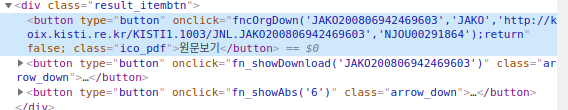

In [64]:
def get_link(keyword):
    a_links=[]
    b_links=[]
    c_links=[]
    urls=[]
    fail=[]

    contents['logKeyword']=keyword
    contents['dsearch']=keyword

    for year in range(2000,2001):
#         contents['pageIndex']=str(page)   # 1~10페이지까지 검색
        contents['dateRange']=[str(year),str(year)]
        contents['rowCount']=100   
        
        req=requests.post(URL,contents)   # 웹 서버에 웹페이지 요청
        code = req.status_code            # 응답 성공 여부
#         print(code)
        if code==200:                     
            soup=bs(req.text) 
            div = soup.find_all('div',{'class','result_item'})
            
            for data in div:
                
                url=data.find('button',{'class':'ico_pdf'}).attrs['onclick']
                url=re.compile("http[^']*")
                
                a_tag=data.find('a',{'title':'상세보기'})
                a_tag=a_tag.get_text()
                a_tag=a_tag.replace('\n','').replace('\t','').replace('\r','').replace('  ','')
                
                b_tag=data.find('div',{'class':'result_item_info'})
                b_tag=b_tag.get_text()
                b_tag=b_tag.replace('\n','').replace('\t','').replace('\r','').replace('  ','')

                try:                        # 초록이 없는 경우 제외
                    box_st1=data.find('div',{"class":"item_content hidden abs"})
                    box_st1=box_st1.get_text()
                    
                except:                      # 초록이 없는 논문 리스크 저장
                    num=data.find('span',{'class','num'}).get_text()
                    fail.append((num,a_tag.replace('  ','')))
                    
                else:                        # 제목과 초록이 있으면 각각 리스트 저장
                    a_links.append(a_tag)
                    b_links.append(b_tag)
                    c_links.append(box_st1)
                    urls.append(url)
        else:                                 # 응답실패
            print('HTTP Error',code)
            
    print("초록 없음 : ")   # 초록 없는것 출력
    for row in fail:
        print(row)
        
    return a_links,b_links,c_links,urls

In [65]:
a,b,c,u=get_link('정보')

AttributeError: 'NoneType' object has no attribute 'attrs'

In [56]:
for row in range(100):
    print(a[row],' : ',u[row])

[국내논문]정보경제와 정보유통의 활성화를 위한 정보공유론(The Information Economy and Information Sharing for an Activation of Information Flow)   :  JAKO200111920894339
[국내논문]디지털정보환경에서의 문헌정보학 교육과정(Curriculum of Library & Information Science in Digital Information Environment)   :  JAKO200011920383803
[국내논문]정보 기술과 환경 의사 결정(Information Technology and Environmental Decision-Making)   :  JAKO200131037072472
[국내논문]정보 수집 최적화 방안에 관한 연구(A Study on Collecting Optimization for KISTI's collection)   :  JAKO200116837842983
[국내논문]KISTI 과학.기술정보 이용자의 정보추구행태 연구(A Study on the Information-Seeking Behavior of ST Information Users of the KISTI)   :  JAKO200116837843011
[국내논문]End-to-End Telecom Billing(완전한 통신사용 정보체계)   :  NPAP08038813
[국내논문]XML 기반 과학기술 정보 처리   :  JAKO200145940709369
[국내논문]한국과학기술정보연구원의 정보유통부문 표준화 현황분석(A Survey on the Standardization of Information Service Sector in KISTI)   :  JAKO200116837843016
[국내논문]특별기고 / 정보 리터러시   :  JAKO200063370245193
[국내논문]여행자 정보 고급화 시스템을 위한 컴포넌트 설계(A Component Design for Advanced Traveler

In [4]:
def save_excel(a_links,b_links,title='test'):
    wb = load('test.xlsx')
    ws=wb.create_sheet(title)
    print('전체 길이',len(a_links))
    
    try:
        for i in range(len(a_links)):
            ws['A'+str(i+1)]=a_links[i]
        for j in range(len(b_links)):
            ws['B'+str(j+1)]=b_links[j]
        wb.save('test.xlsx')
        
    except Exception as e:
        print(e)
        
    finally:
        wb.close()  

In [6]:
ok=Okt()
ok.pos("논문의 제목과 초록에 사용된 명사 빈도 비교")

[('논문', 'Noun'),
 ('의', 'Josa'),
 ('제목', 'Noun'),
 ('과', 'Josa'),
 ('초록', 'Noun'),
 ('에', 'Josa'),
 ('사용', 'Noun'),
 ('된', 'Verb'),
 ('명사', 'Noun'),
 ('빈도', 'Noun'),
 ('비교', 'Noun')]

In [7]:
mpl.use('TkAgg')  # 그래프 지원 

PATH='/usr/share/fonts/NanumFont/NanumGothic.ttf'  # 글꼴 
def get_wc(content,title):
    ok=Okt()
    result={}
    for c in content:          
            temp = ok.pos(c)  # 형태소 분석
            for t in temp:
                if t[1] =="Noun" and len(t[0])>1:  # 명사이고 글자수가 1 이상이면 실행
                    
                    if not (t[0] in result):       # 딕셔너리에 t[0]가 없으면 key값을 t[0]으로 선언
                        result[t[0]]=0
                    result[t[0]]+=1
                    
    result = sorted(result.items(),key = lambda x:x[1],reverse=True)  겟수가 많은것부터 정렬
    print(dict(result))
    wc=WordCloud(font_path=PATH,background_color = 'white',width = 800, height=600)
    plt.axis('off')
    plt.imshow(wc.generate_from_frequencies(dict(result)))
    plt.savefig(title+'.jpg')           # 저장


In [9]:
if __name__=="__main__":
#     try:
#         while True:
            keyword = input('검색어를 입력해주세요. : ')
#             if keyword=="exit":
#                 print('종료되었습니다.')
#                 break
            a_links,b_links=get_link(str(keyword))
            title = input('엑셀 시트명을 입려해주세요 : ')
            save_excel(a_links,b_links,title=title)
            a,b=input('이미지 이름을 입력해주세요. (1: 제목, 2: 초록) : ').split()
            get_wc(a_links,a)
            get_wc(b_links,b)
#     except Exception as e:
#         print(e)

검색어를 입력해주세요. : 정보
초록 없음 : 
('13.', '[학위논문]지질정보 시스템 ')
('24.', '[학위논문]지리정보 메타데이터 관리 시스템 구현 ')
('29.', '[학위논문]대학생의 정신건강정보 이해능력(Mental Health Literacy)에 미치는 영향 요인(Factors Influencing on Mental Health Literacy Among University Students) ')
('36.', '[국내논문]정보경찰 교육의 피이드백 시스템 확보방안(A Study on Effective Feed Back System of Intelligence Police Education) ')
('48.', "[국내논문]간호정보시스템이 간호업무에 미치는 영향 - 직？간접 간호시간 중심으로(The Effects of Nursing Information System on the Nursing Job-Focused on Direct and Indirect Nursing Time, the Number of Cases and of Patient's Treatment Fees) ")
('98.', '[학위논문]건강정보 이해능력을 고려한 노인 당뇨병 자기관리 프로그램 개발 및 효과평가 ')
엑셀 시트명을 입려해주세요 : 정보
전체 길이 94
이미지 이름을 입력해주세요. (1: 제목, 2: 초록) : 정보_title 정보_body
{'논문': 95, '정보': 82, '학위': 66, '연구': 48, '국내': 28, '방안': 14, '활용': 13, '분석': 13, '공간': 13, '영향': 11, '시스템': 11, '이용': 9, '중심': 9, '정보보안': 9, '효과': 9, '의료': 9, '기반': 8, '대한': 7, '개인': 7, '통한': 7, '교육': 7, '도서관': 7, '관리': 6, '간호': 6, '문헌정보학': 5, '특허': 5, '정보격차': 5, '보안': 5, '개발': 5, '제공': 5, '서비스'